## Imports

In [272]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold


## Loading the dataset

In [273]:
dataset = pd.read_csv('advertisement.csv')
dataset.head()


,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
0,45,Male,61271.953359,Master,False,3,Lake Sheila,Doctor,87.697118,monitor,electronics clothing sports
1,24,Female,53229.101074,High School,False,1,Crystalburgh,Businessman,115.135586,lipstick,furniture beauty
2,45,Female,30066.046684,Bachelor,True,3,Margaretburgh,Engineer,101.694559,biscuits,clothing electronics food sports
3,19,Male,48950.246384,PhD,False,0,Williamshaven,Lawyer,97.964887,maggi,food
4,29,Female,44792.627094,Master,False,0,New Paul,Businessman,86.847281,carpet,home


## Visualizing the dataset

/var/folders/nv/y38dbr6d15s8w3kl0j4ysj700000gn/T/ipykernel_11855/2296518511.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, 1)


<Axes: title={'center': 'Frequency values of most bought item'}, xlabel='most bought item', ylabel='Frequencies'>

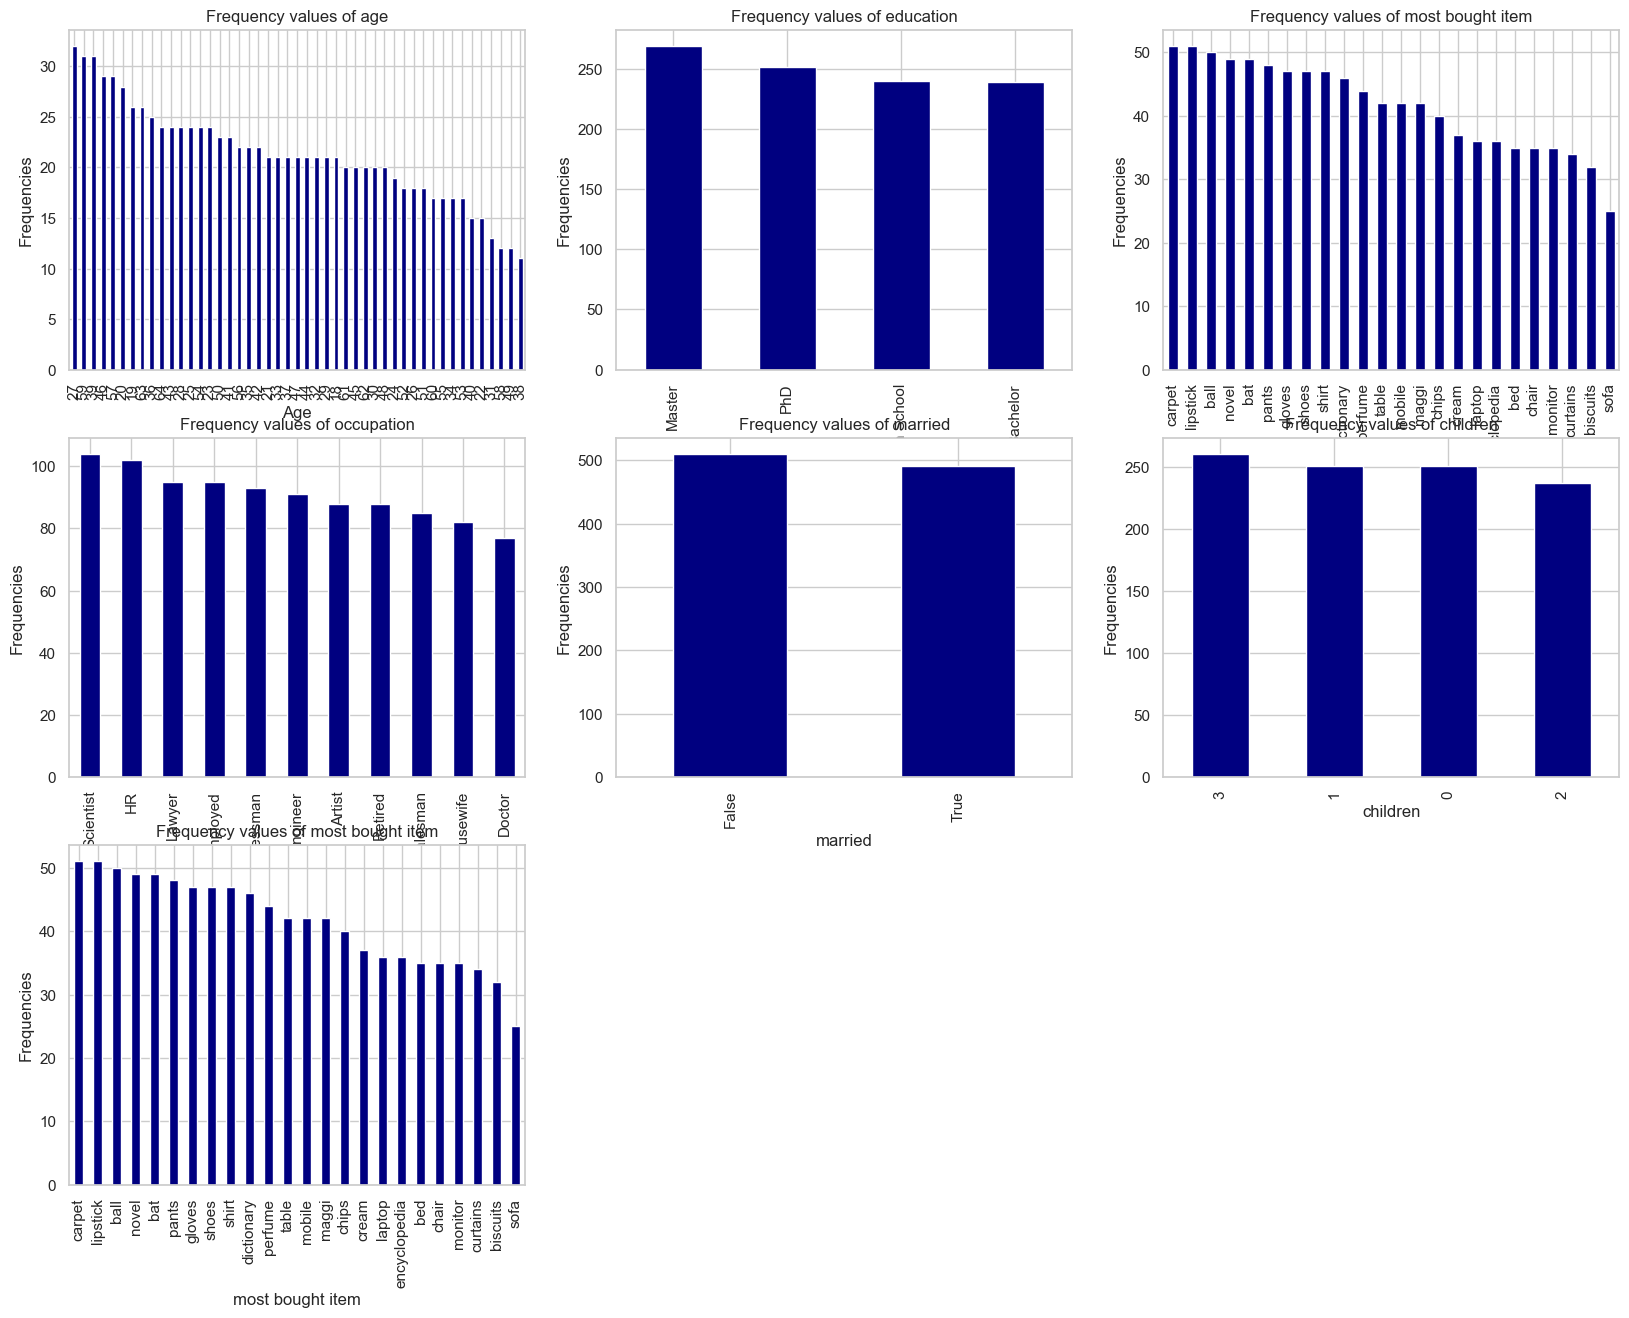

In [274]:
fig, ax = plt.subplots()

# plot 6 plots in a 2x3 grid
fig.set_figheight(15)
fig.set_figwidth(20)

# plot 1
ax = plt.subplot(3, 3, 1)
ax.set_title(f"Frequency values of age")
ax.set_xlabel("Age")
ax.set_ylabel("Frequencies")
dataset['age'].value_counts().plot(ax=ax, kind='bar', color='navy')

# plot 2
ax = plt.subplot(3, 3, 2)
ax.set_title(f"Frequency values of education")
ax.set_xlabel("Education")
ax.set_ylabel("Frequencies")
dataset['education'].value_counts().plot(ax=ax, kind='bar', color='navy')

# plot 3
ax = plt.subplot(3, 3, 3)
ax.set_title(f"Frequency values of most bought item")
ax.set_xlabel("most bought item")
ax.set_ylabel("Frequencies")
dataset['most bought item'].value_counts().plot(ax=ax, kind='bar', color='navy')

# plot 4
ax = plt.subplot(3, 3, 4)
ax.set_title(f"Frequency values of occupation")
ax.set_xlabel("occupation")
ax.set_ylabel("Frequencies")
dataset['occupation'].value_counts().plot(ax=ax, kind='bar', color='navy')

# plot 5
ax = plt.subplot(3, 3, 5)
ax.set_title(f"Frequency values of married")
ax.set_xlabel("married")
ax.set_ylabel("Frequencies")
dataset['married'].value_counts().plot(ax=ax, kind='bar', color='navy')

# plot 6
ax = plt.subplot(3, 3, 6)
ax.set_title(f"Frequency values of children")
ax.set_xlabel("children")
ax.set_ylabel("Frequencies")
dataset['children'].value_counts().plot(ax=ax, kind='bar', color='navy')

# plot 7
ax = plt.subplot(3, 3, 7)
ax.set_title(f"Frequency values of most bought item")
ax.set_xlabel("most bought item")
ax.set_ylabel("Frequencies")
dataset['most bought item'].value_counts().plot(ax=ax, kind='bar', color='navy')



### Plotting income distribution

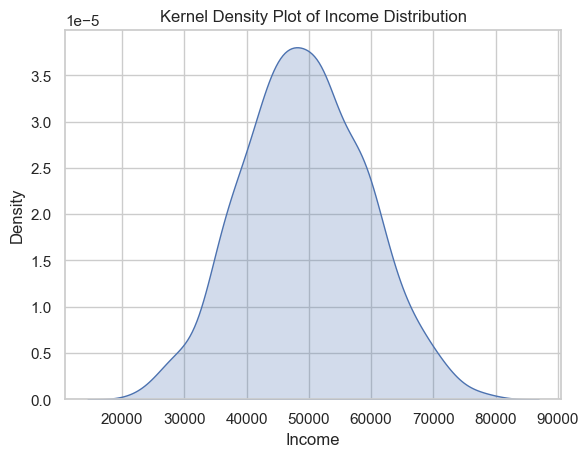

In [275]:
sns.set(style="whitegrid")
sns.kdeplot(dataset['income'], fill=True)
plt.xlabel('Income')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Income Distribution')
plt.show()

### Plotting a histogram showing distribution of labels in the dataset

In [276]:
label_data = dataset['labels'].str.split(" ").tolist()
flattened_labels = [item for sublist in label_data for item in sublist]
distinct_labels, counts = np.unique(flattened_labels, return_counts=True)
print(f"Total distinct labels: {distinct_labels.size}")
print(distinct_labels)


Total distinct labels: 8
['beauty' 'books' 'clothing' 'electronics' 'food' 'furniture' 'home'
 'sports']


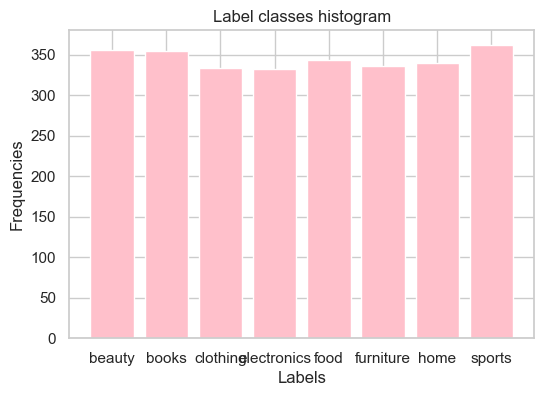

In [277]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.set_title("Label classes histogram")
ax.set_xlabel("Labels")
ax.set_ylabel("Frequencies")
ax.bar(distinct_labels, counts, color='pink')

plt.show()

## Base Decision Tree Classifier

The code for the decision tree classifier classes has been taken partly from chatGPT, partly from the sklearn documentation and partly written by me

In [278]:
class BaseDecisionTreeClassifier():
    def __init__(self , max_depth = None, max_features = None , criterion = 'gini'):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.clf = None
        self.labels_dict = None
        self.encoders = None
        self.train_cols = None
    
    def encoding_categorical_variables(self , categorical_variables , X_en):
        encoders = {}
        for variable in categorical_variables:
            # Initialize encoder and get unique categories
            encoder = OneHotEncoder()
            unique_categories = X_en[variable].unique().reshape(-1, 1)
            
            # Fit encoder and store it
            encoder.fit(unique_categories)
            encoders[variable] = encoder
            
            # Transform variable into one-hot encoded format
            transformed_data = encoder.transform(X_en[variable].to_numpy().reshape(-1, 1)).toarray()
            
            # Create column names for the one-hot encoded data
            col_names = [f"{variable}_{i}" for i in range(len(unique_categories))]
            
            # Convert the transformed data into DataFrame and concatenate with original data
            one_hot_df = pd.DataFrame(transformed_data, columns=col_names)
            X_en = pd.concat([X_en, one_hot_df], axis=1)
            
            # Drop the original categorical column
            X_en.drop(variable, axis=1, inplace=True)

        return X_en , encoders
    
    def fit(self , X_tr , y , encode = True):
        # Encoding labels if required
        if encode:
            y, labels_dict = self.encoding_labels(y)
        else:
            labels_dict = None

        # Identify numeric and categorical columns
        numeric_cols = X_tr._get_numeric_data().columns
        categorical_cols = list(set(X_tr.columns) - set(numeric_cols))

        # Encode categorical variables
        X_tr, encoders = self.encoding_categorical_variables(categorical_cols, X_tr)

        # Initialize and train the classifier
        clf = DecisionTreeClassifier(
            random_state=42,
            criterion=self.criterion,
            max_depth=self.max_depth,
            max_features=self.max_features
        )
        clf.fit(X_tr, y)

        # Store necessary attributes
        self.clf = clf
        self.train_cols = X_tr.columns
        self.labels_dict = labels_dict
        self.encoders = encoders

    
    def predict(self , X_te , decode = True):
        cols = X_te.columns
    
        numeric_cols = X_te._get_numeric_data().columns
        categorical_cols = list(set(cols) - set(numeric_cols))
    
        for variable in categorical_cols:
            category_list = X_te[variable].fillna(X_te[variable].mode().iloc[0]).unique().reshape(1,-1)
            encoder = self.encoders[variable]
            train_categories = np.array(encoder.categories_)

            combined_categories = np.unique(np.concatenate((category_list, train_categories), axis=1))
            combined_categories = combined_categories.reshape(-1,1)

            encoder.categories_ = combined_categories
            encoder.fit(combined_categories)
            
            one_hot_encoded = encoder.transform(X_te[variable].fillna(X_te[variable].mode().iloc[0]).to_numpy().reshape(-1,1)).toarray()
            num_cols = len(combined_categories)
            col_names = [variable + '_' + str(i) for i in range(num_cols)]
            one_hot_encoded_df = pd.DataFrame(one_hot_encoded , columns = col_names)

            X_te.reset_index(drop = True , inplace = True)
            one_hot_encoded_df.reset_index(drop = True , inplace = True)

            X_te = pd.concat([X_te , one_hot_encoded_df] , axis = 1)
            X_te = X_te.drop(variable , axis = 1)
            
        # Contain only those columns which are present in train
        X_te = X_te[self.train_cols]
        X_te = X_te.fillna(X_te.mode().iloc[0])
        y_pred = self.clf.predict(X_te)
        if decode:
            y_pred = self.decoding_labels(y_pred)
        return y_pred

### PowerSet Decision Tree Classifier (inherits from Base Decision Tree Classifier)

In [279]:
class DecisionTreeClassifierPowerSet(BaseDecisionTreeClassifier):
    def decoding_labels(self, y_en):
        """Decode encoded labels back to their original form."""
        labels_dict = self.labels_dict
        return [' '.join(key) for class_name in y_en for key, value in labels_dict.items() if value == class_name]

    def encoding_labels(self, y):
        """Encode labels into a unique representation and store the mapping in a dictionary."""
        
        # Extract unique label combinations and convert them into frozensets
        labels_list = [frozenset(labels.split(' ')) for labels in y]
        
        # Create a dictionary to map each unique set of labels to a class name
        labels_dict = {label_set: f"Class_{index}" for index, label_set in enumerate(set(labels_list))}
        
        # Transform the input labels into their encoded representation using the labels_dict
        y_encoded = y.apply(lambda x: labels_dict[frozenset(x.split(' '))])
        
        return y_encoded, labels_dict


### Multioutput Decision Tree Classifier (inherits from Base Decision Tree Classifier)

In [280]:
class DecisionTreeClassifierMultiOutput():
    def __init__(self , max_depth = None, max_features = None , criterion = 'gini'):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.clf = None
        self.labels_dict = None
        self.encoders = None
        self.train_cols = None

    def fit(self , X_tr , y):
        y_encoded , labels_dict = self.encoding_labels(y)
        num_labels = y_encoded.shape[1]
        list_clfs = []
        for i in range(num_labels):
            temp_clf = DecisionTreeClassifier_Parent(
                criterion = self.criterion,
                max_depth = self.max_depth,
                max_features = self.max_features
            )   

            temp_clf.fit(X_tr , y_encoded[:,i] , encode = False)
            list_clfs.append(temp_clf)
        
        self.labels_dict = labels_dict
        self.clf = list_clfs
    
    def predict(self , X_te):
        y_pred = []
        for clf_ in self.clf:
            y_predi = clf_.predict(X_te , decode = False)
            y_pred.append(y_predi)
        
        y_pred = np.array(y_pred)
        y_pred = y_pred.T
        y_pred = self.decoding_labels(y_pred)
        return y_pred        
    
    
    def decoding_labels(self , y_en): 
        mlb = self.labels_dict
        y_de = mlb.inverse_transform(y_en)
        y_de = [' '.join(list(frozenset(x)))  for x in y_de]
        return y_de

    def encoding_labels(self , y):
        mlb = MultiLabelBinarizer()
        y = y.apply(lambda x: x.split(' '))
        mlb.fit(y)
        y_en = mlb.transform(y)
        return y_en , mlb
        

In [281]:
def run_decision_tree(data, columns_to_drop, max_depth=30, max_features=9):
    total_data = dataset.copy()
    X = total_data.drop(columns=columns_to_drop)
    y = total_data['labels']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    decision_tree = DecisionTreeClassifierMultiOutput(max_depth=max_depth, max_features=max_features)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    y_test = y_test.apply(lambda x: ' '.join(list(frozenset(x.split(' ')))))

    print(y_pred)
    acc = accuracy_score(y_test, y_pred)
    print(acc)

In [282]:
data_columns_to_drop = [
    ['labels', 'income', 'married'],
    ['labels', 'income'],
    ['labels', 'income', 'city'],
    ['labels', 'income', 'occupation'],
    ['labels', 'income', 'most bought item']
]

for cols in data_columns_to_drop:
    run_decision_tree(dataset, cols)

['', '', 'sports clothing', '', 'electronics', '', 'books', '', 'beauty', '', '', '', 'food', '', 'beauty', 'electronics', '', '', 'clothing home books furniture', 'furniture', 'home sports', '', '', '', 'electronics', 'furniture', 'electronics furniture beauty', 'food clothing beauty', 'food', 'furniture', 'furniture', 'food', 'electronics sports furniture', '', 'clothing', '', 'beauty', 'food', '', '', 'home sports beauty', 'furniture beauty', '', '', '', '', 'beauty', '', 'beauty', '', 'clothing', '', 'food', 'food', '', '', 'electronics', '', 'clothing', '', 'electronics furniture', '', 'clothing sports books beauty', '', '', '', 'electronics furniture beauty', 'furniture', '', '', 'electronics', 'beauty', 'beauty', '', '', '', 'food', 'electronics home sports', 'home clothing beauty', '', '', 'electronics', 'furniture books', 'clothing', 'furniture', '', 'home sports', '', '', '', 'books', '', '', '', 'furniture', 'books beauty', '', '', '', '', '', 'food books', 'electronics', 'b

In [283]:
CLASSIFIERS = {
    'PowerSet': DecisionTreeClassifierPowerSet,
    'MultiOutput': DecisionTreeClassifierMultiOutput
}

In [284]:
def fit_and_evaluate_classifier(clf_name, crit, max_d, max_fts, X_train, X_test, y_train, y_test):
    clf = CLASSIFIERS[clf_name](criterion=crit, max_depth=max_d, max_features=max_fts)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_test = y_test.apply(lambda x: ' '.join(list(frozenset(x.split(' ')))))
    
    return {
        'Classifier': clf_name,
        'Criterion': crit,
        'Max_Depth': max_d,
        'Max_Features': max_fts,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='micro'),
        'Recall': recall_score(y_test, y_pred , average='micro'),
        'F1_Micro': f1_score(y_test, y_pred , average='micro'),
        'F1_Macro': f1_score(y_test, y_pred , average='macro'),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

In [285]:
def get_top_performers(logs, n=3):
    return pd.DataFrame(sorted(logs, key=lambda x: x['F1_Micro'], reverse=True)[:n])

In [286]:
def perform_kfold_evaluation(best_settings, X, y, n_splits=5):
    logs = []
    kf = KFold(n_splits=n_splits)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]
        
        for clf_name in CLASSIFIERS.keys():
            log = fit_and_evaluate_classifier(clf_name, best_settings[clf_name]['Criterion'], best_settings[clf_name]['Max_Depth'], best_settings[clf_name]['Max_Features'], X_train, X_test, y_train, y_test)
            log['Fold'] = fold + 1
            logs.append(log)
    
    return pd.DataFrame(logs)

In [287]:
# data = pd.read_csv("advertisement.csv")
criterion = ['gini', 'entropy']
max_depth = [3,5,10,20,30]
max_features = [3,5,7,9,11]

X = dataset.drop(columns=['labels' ,'income'])
y = dataset['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

logs = []
for clf_name in CLASSIFIERS.keys():
    for crit in criterion:
        for max_d in max_depth:
            for max_fts in max_features:
                logs.append(fit_and_evaluate_classifier(clf_name, crit, max_d, max_fts, X_train, X_test, y_train, y_test))

df_logs = pd.DataFrame(logs)
df_logs.to_csv('logs.csv', index=False)

df_logs.head()
print(df_logs)

     Classifier Criterion  Max_Depth  Max_Features  Accuracy  Precision  \
0      PowerSet      gini          3             3     0.040      0.040   
1      PowerSet      gini          3             5     0.044      0.044   
2      PowerSet      gini          3             7     0.040      0.040   
3      PowerSet      gini          3             9     0.040      0.040   
4      PowerSet      gini          3            11     0.036      0.036   
..          ...       ...        ...           ...       ...        ...   
95  MultiOutput   entropy         30             3     0.016      0.016   
96  MultiOutput   entropy         30             5     0.032      0.032   
97  MultiOutput   entropy         30             7     0.024      0.024   
98  MultiOutput   entropy         30             9     0.032      0.032   
99  MultiOutput   entropy         30            11     0.028      0.028   

    Recall  F1_Micro  F1_Macro  \
0    0.040     0.040  0.002591   
1    0.044     0.044  0.004335 